In [1]:
import sys
import os
import pandas
import numpy as np 
import io 
from rdkit import Chem
sys.path.append("../")
import mol_cv
import load_medchem_data
import predict_medchem
import PIL
from collections import Counter

In [2]:
predictor_dict =  { k:v() for k,v in predict_medchem.all_predictors().items()}
fda = load_medchem_data.load_fda_drugs()
mols = fda["mol"]
fda["cluster"] = predict_medchem.cluster(mols=mols,
                                         fingerprint_size=1024, cutoff=0.5)
counter = Counter(fda["cluster"])
fda["cluster_size"] = fda["cluster"].map(counter)
cluster_1 = fda.loc[fda["cluster"] == 2,"mol"]

Getting distances: 100%|██████████████████████████████████████████████████████████| 1613/1613 [00:00<00:00, 4224.20it/s]


In [3]:
df = pandas.DataFrame({"SMILES":[Chem.MolToSmiles(m) for m in cluster_1]})
df.to_csv("cluster_example.csv",index=False)
mols = [ Chem.MolFromSmiles(s) for s in pandas.read_csv("../data/cluster_example.csv")["SMILES"]]

In [6]:
%%capture
images = mol_cv.align_and_plot(mols,output_file='animated_plot.gif')

(np.float64(-0.5), np.float64(2069.5), np.float64(515.5), np.float64(-0.5))

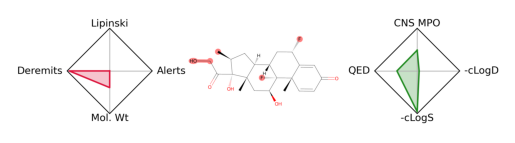

In [7]:
from matplotlib import pyplot as plt 
plt.imshow(images[0])
plt.axis("off")